In [ ]:
# ============================================================
# FEATURE ENGINEERING NOTEBOOK 
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer,FeatureHasher, HashingVectorizer

from sklearn.feature_selection import VarianceThreshold
from geopy.distance import geodesic
import xgboost as xgb
import shap
from sklearn.linear_model import Lasso

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

# ------------------------------------------------------------
# REUSABLE DIAGNOSTICS FUNCTION
# ------------------------------------------------------------

def plot_distribution_diagnostics(
    series,
    transform=None,   # None, "log", "sqrt", "boxcox", "yeojohnson"
    title="Feature"
):
    """
    Plots histogram + QQ plot + skewness/kurtosis before & after transformation.
    """

    # -----------------------------
    # Prepare data
    # -----------------------------
    x = series.dropna()

    # -----------------------------
    # Apply transformation
    # -----------------------------
    if transform == "log":
        x_trans = np.log1p(x)
        t_name = "Log Transform"

    elif transform == "sqrt":
        x_trans = np.sqrt(x)
        t_name = "Square Root Transform"

    elif transform == "boxcox":
        pt = PowerTransformer(method="box-cox")
        x_trans = pt.fit_transform(x.values.reshape(-1, 1)).flatten()
        x_trans = pd.Series(x_trans, index=x.index)   # FIX
        t_name = "Box-Cox Transform"

    elif transform == "yeojohnson":
        pt = PowerTransformer(method="yeo-johnson")
        x_trans = pt.fit_transform(x.values.reshape(-1, 1)).flatten()
        x_trans = pd.Series(x_trans, index=x.index)   # FIX
        t_name = "Yeo-Johnson Transform"

    else:
        x_trans = x
        t_name = "No Transform"

    # -----------------------------
    # Metrics
    # -----------------------------
    skew_before, kurt_before = x.skew(), x.kurt()
    skew_after, kurt_after = x_trans.skew(), x_trans.kurt()

    print(f"\n=== {title} — BEFORE ===")
    print(f"Skewness: {skew_before:.4f}")
    print(f"Kurtosis: {kurt_before:.4f}")

    print(f"\n=== {title} — AFTER ({t_name}) ===")
    print(f"Skewness: {skew_after:.4f}")
    print(f"Kurtosis: {kurt_after:.4f}")

    # -----------------------------
    # PLOTS
    # -----------------------------
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Histogram before
    sns.histplot(x, bins=20, kde=True, ax=axes[0, 0], color="salmon")
    axes[0, 0].set_title(f"{title} — Before")

    # Histogram after
    sns.histplot(x_trans, bins=20, kde=True, ax=axes[0, 1], color="seagreen")
    axes[0, 1].set_title(f"{title} — After ({t_name})")

    # QQ plot before
    stats.probplot(x, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title("QQ Plot — Before")

    # QQ plot after
    stats.probplot(x_trans, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f"QQ Plot — After ({t_name})")

    plt.tight_layout()
    plt.show()

    return x_trans


# ------------------------------------------------------------
# SAMPLE DATASET
# ------------------------------------------------------------
df = pd.DataFrame({
    "income": [30000, 35000, 90000, 150000, 500000],
    "age": [22, 35, 45, 29, 60],
    "city": ["NY", "SF", "NY", "LA", "SF"],
    "merchant_id": [
        "M123", "M987", "M555", "M123", "M777"],
    "review": [
        "Great product and fast delivery",
        "Terrible experience, not recommended",
        "Good value for money",
        "Average quality but okay",
        "Excellent and worth the price"
    ],
    "timestamp": pd.date_range("2023-01-01", periods=5, freq="D"),
    "sales": [100, 120, 130, 90, 150],
    "lat1": [40.7128]*5,
    "lon1": [-74.0060]*5,
    "lat2": [34.0522]*5,
    "lon2": [-118.2437]*5,
 
})

df

,income,age,city,merchant_id,review,timestamp,sales,lat1,lon1,lat2,lon2
0,30000,22,NY,M123,Great product and fast delivery,2023-01-01,100,40.7128,-74.006,34.0522,-118.2437
1,35000,35,SF,M987,"Terrible experience, not recommended",2023-01-02,120,40.7128,-74.006,34.0522,-118.2437
2,90000,45,NY,M555,Good value for money,2023-01-03,130,40.7128,-74.006,34.0522,-118.2437
3,150000,29,LA,M123,Average quality but okay,2023-01-04,90,40.7128,-74.006,34.0522,-118.2437
4,500000,60,SF,M777,Excellent and worth the price,2023-01-05,150,40.7128,-74.006,34.0522,-118.2437


# Feature Transformation Techniques
  - Log
  - YeoJhonson
  - Scaler
  - Bining



=== Income — BEFORE ===
Skewness: 1.9110
Kurtosis: 3.7538

=== Income — AFTER (Log Transform) ===
Skewness: 0.6643
Kurtosis: -0.4561


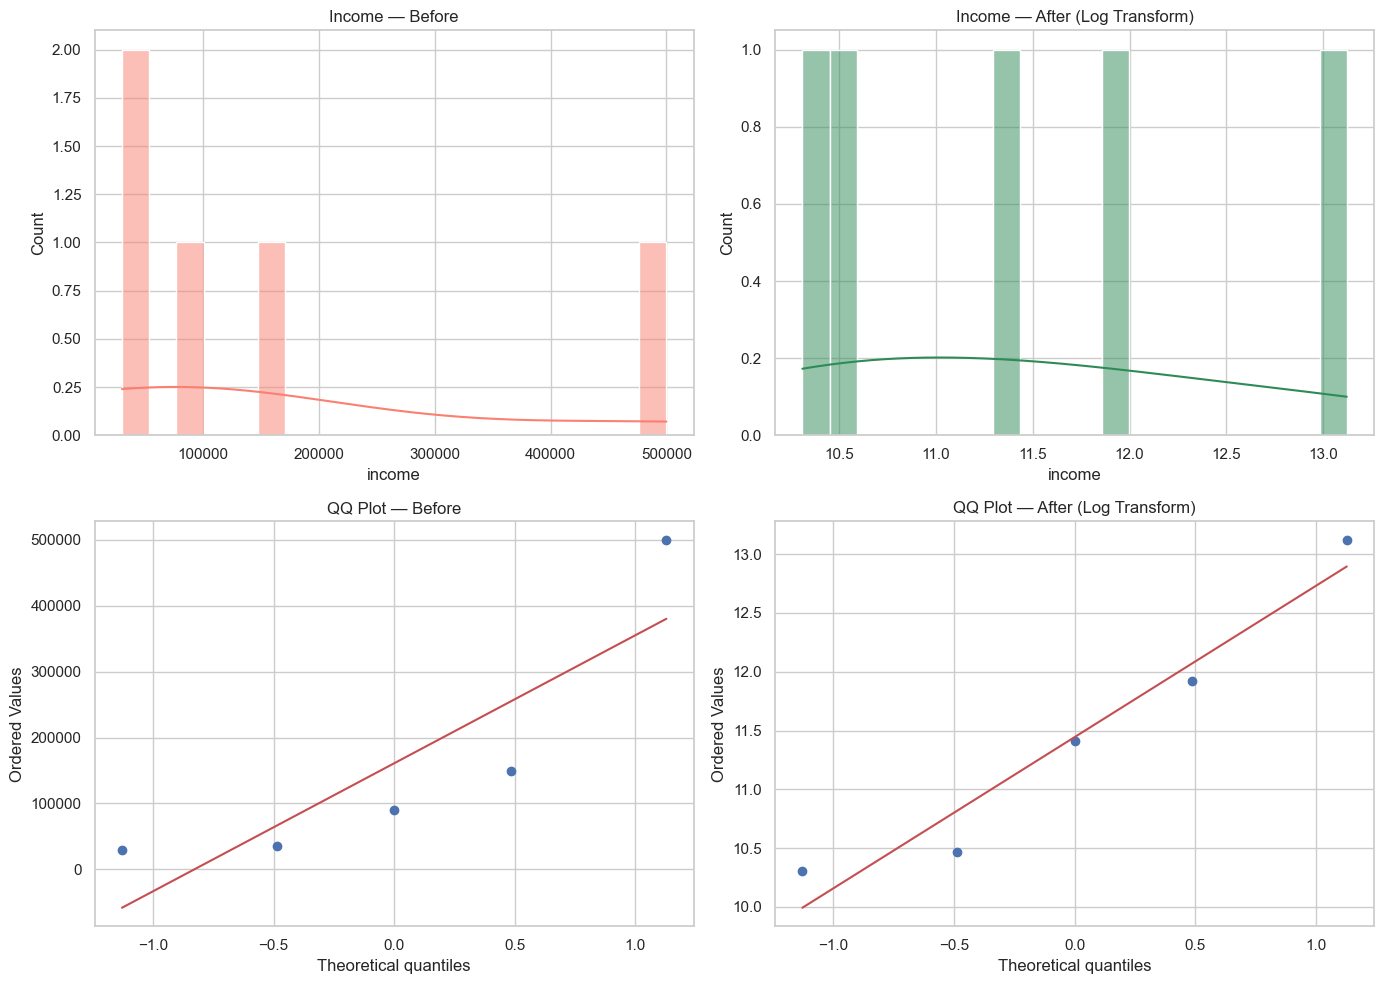

In [58]:
df["income_log"] = plot_distribution_diagnostics(
    df["income"],
    transform="log",
    title="Income"
)


=== Income — BEFORE ===
Skewness: 1.9110
Kurtosis: 3.7538

=== Income — AFTER (Yeo-Johnson Transform) ===
Skewness: 0.2178
Kurtosis: -1.5971


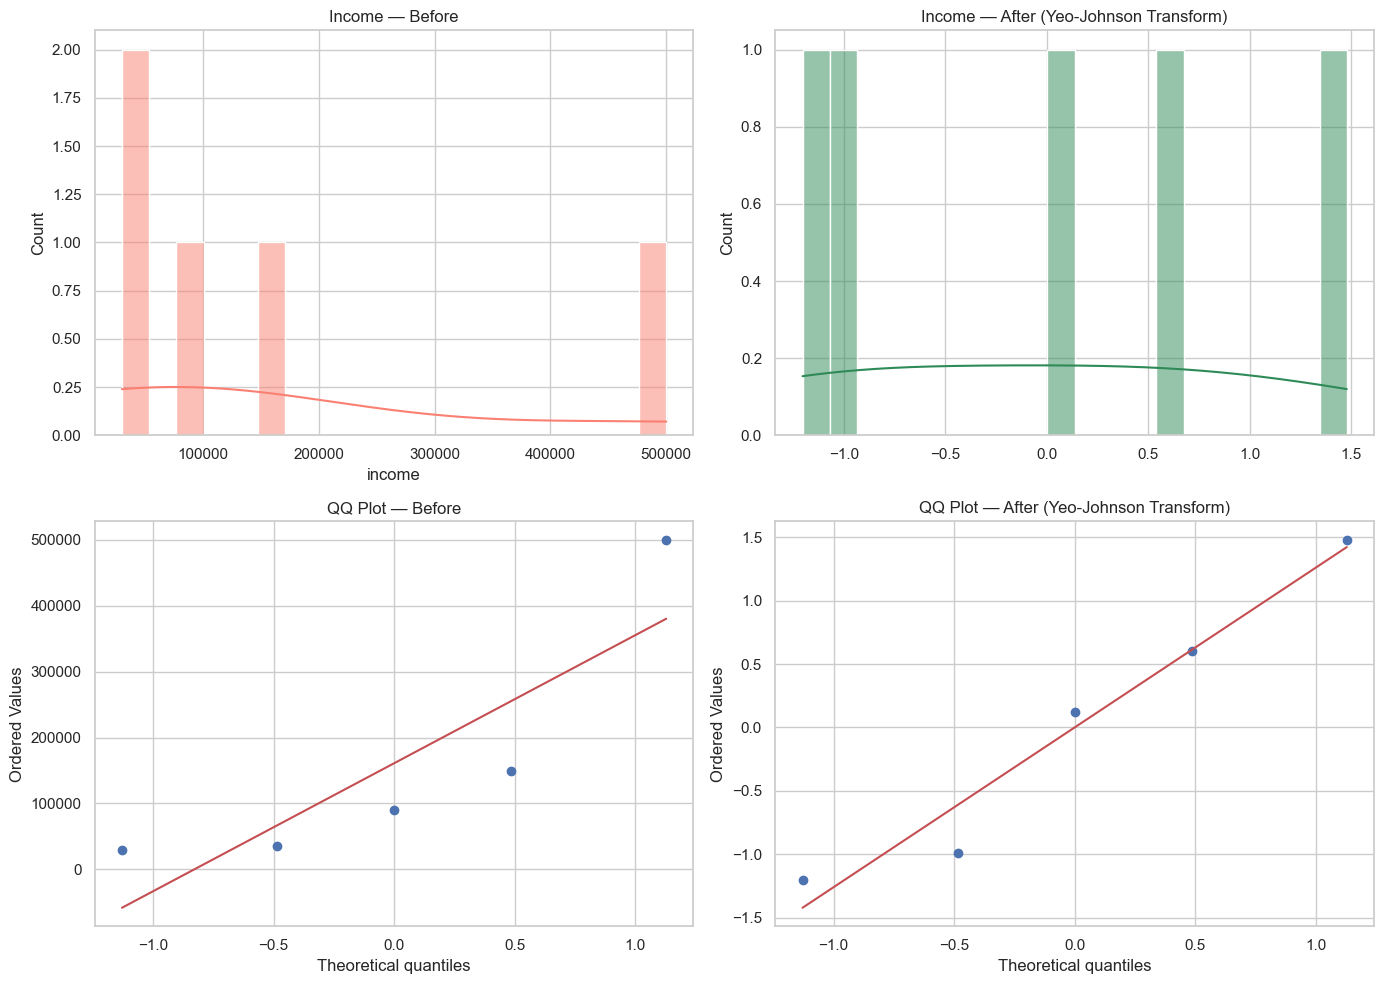

In [59]:
df["income_yj"] = plot_distribution_diagnostics(
    df["income"],
    transform="yeojohnson",
    title="Income"
)

In [60]:
scaler = StandardScaler()
df["age_scaled"] = scaler.fit_transform(df[["age"]])
df[["age", "age_scaled"]]

,age,age_scaled
0,22,-1.221954
1,35,-0.241374
2,45,0.512919
3,29,-0.693949
4,60,1.644358


In [61]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 18, 35, 60, 100],
    labels=["teen", "young", "adult", "senior"]
)
df[["age", "age_group"]]

,age,age_group
0,22,young
1,35,young
2,45,adult
3,29,young
4,60,adult


# Feature Encoding
 - One Hot Encoding
 - Label
 - Embeddings
 - Feature Hashing

In [62]:
# OHE
df_encoded = pd.get_dummies(df, columns=["city"], drop_first=True)
df_encoded.filter(regex="city_").head()

,city_NY,city_SF
0,True,False
1,False,True
2,True,False
3,False,False
4,False,True


In [63]:
le = LabelEncoder()
df["city_le"] = le.fit_transform(df["city"])
df[["city", "city_le"]]


,city,city_le
0,NY,1
1,SF,2
2,NY,1
3,LA,0
4,SF,2


In [64]:
tfidf = TfidfVectorizer(max_features=5)
tfidf_matrix = tfidf.fit_transform(df["review"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"tfidf_{i}" for i in range(5)])
tfidf_df.head()

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4
0,0.627914,0.000000,0.000000,0.778283,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.707107,0.707107,0.000000,0.000000
4,0.627914,0.000000,0.000000,0.000000,0.778283


In [65]:


# Convert to list of dicts (required by FeatureHasher)
records = df["merchant_id"].apply(lambda x: {"merchant_id": x})

# ------------------------------------------------------------
# Apply Feature Hashing
# ------------------------------------------------------------
hasher = FeatureHasher(n_features=8, input_type="dict")
hashed_features = hasher.transform(records)

hashed_df = pd.DataFrame(hashed_features.toarray())
hashed_df



,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
#Text Hashing:  similar to feature hashing but for text data, where each token is hashed into a fixed number of dimensions.
vec = HashingVectorizer(n_features=32)
X = vec.transform(df["review"])
hashed_df = pd.DataFrame(X.toarray())
hashed_df.head()




,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,-0.447214,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.447214,0.447214,0.0,0.000000,0.0
1,0.0,0.0,-0.707107,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.5,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.5,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.0
4,0.0,0.0,0.000000,0.0,0.0,-0.447214,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,-0.447214,0.0


# Creating New features from existing ones:  e.g., distance between two points, or interaction terms between features.
 - Date Time
 - Time Shift
 - Distance

In [67]:
# Creating new features from datetime
df["year"] = df["timestamp"].dt.year
df["weekday"] = df["timestamp"].dt.weekday
df["hour"] = df["timestamp"].dt.hour
df[["timestamp", "year", "weekday", "hour"]]

,timestamp,year,weekday,hour
0,2023-01-01,2023,6,0
1,2023-01-02,2023,0,0
2,2023-01-03,2023,1,0
3,2023-01-04,2023,2,0
4,2023-01-05,2023,3,0


In [68]:
df["sales_lag_1"] = df["sales"].shift(1)
df["sales_roll_3"] = df["sales"].rolling(3).mean()
df[["sales", "sales_lag_1", "sales_roll_3"]]

,sales,sales_lag_1,sales_roll_3
0,100,NaN,NaN
1,120,100.0,NaN
2,130,120.0,116.666667
3,90,130.0,113.333333
4,150,90.0,123.333333


In [69]:
df["distance_km"] = df.apply(
    lambda row: geodesic((row.lat1, row.lon1), (row.lat2, row.lon2)).km,
    axis=1
)
df[["distance_km"]]

,distance_km
0,3944.422231
1,3944.422231
2,3944.422231
3,3944.422231
4,3944.422231


In [70]:
df["price_per_unit"] = df["sales"] / (df["age"] + 1)
df["income_to_age"] = df["income"] / df["age"]
df[["price_per_unit", "income_to_age"]]

,price_per_unit,income_to_age
0,4.347826,1363.636364
1,3.333333,1000.000000
2,2.826087,2000.000000
3,3.000000,5172.413793
4,2.459016,8333.333333


# Feature Selection Techniques
 - Variance
 - SHAP
 - LASSO

In [71]:
# Feature selection with Variance Threshold
X = df_encoded.select_dtypes(include=[np.number]).fillna(0)

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()]).head()

,income,age,sales,income_log,income_yj,age_scaled
0,30000.0,22.0,100.0,10.308986,-1.205216,-1.221954
1,35000.0,35.0,120.0,10.463132,-0.992141,-0.241374
2,90000.0,45.0,130.0,11.407576,0.118122,0.512919
3,150000.0,29.0,90.0,11.918397,0.599420,-0.693949
4,500000.0,60.0,150.0,13.122365,1.479815,1.644358


# SHAP for Feature Selection
 Unlike correlation filtering or variance thresholds, SHAP understands the model.
 It measures how much each feature actually changes the prediction.
 The result is a ranked list of features based on real predictive impact — even when relationships are nonlinear or features interact.
 This makes SHAP one of the most reliable ways to select features for tree‑based models.


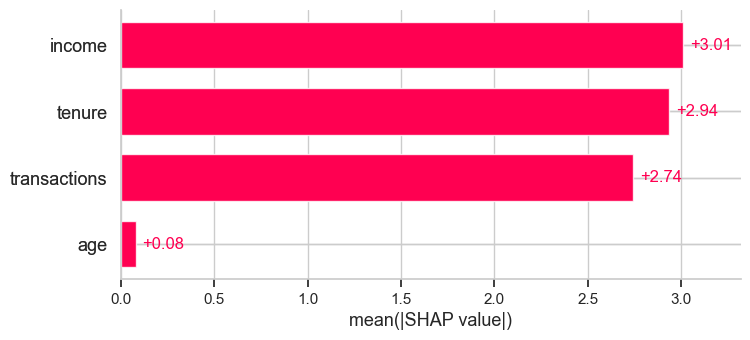

In [72]:

# ------------------------------------------------------------
# Create SHAP dataset
# ------------------------------------------------------------
np.random.seed(42)

n = 300
df = pd.DataFrame({
    "age": np.random.randint(18, 70, n),
    "income": np.random.randint(20000, 200000, n),
    "transactions": np.random.randint(1, 50, n),
    "tenure": np.random.randint(1, 15, n)
})

# Target with real signal
df["fraud_flag"] = (
    (df["transactions"] > 25).astype(int) +
    (df["income"] < 50000).astype(int) +
    (df["tenure"] < 3).astype(int)
)
df["fraud_flag"] = (df["fraud_flag"] > 1).astype(int)

X = df.drop("fraud_flag", axis=1)
y = df["fraud_flag"]

# ------------------------------------------------------------
# Train XGBoost model
# ------------------------------------------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)
model.fit(X, y)

# ------------------------------------------------------------
# SHAP Explainer
# ------------------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# ------------------------------------------------------------
# Global Feature Importance
# ------------------------------------------------------------
shap.plots.bar(shap_values)

In [73]:
# Mean absolute SHAP value per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "shap_importance": shap_importance
}).sort_values("shap_importance", ascending=False)

print(importance_df)

        feature  shap_importance
1        income         3.011188
3        tenure         2.936570
2  transactions         2.743793
0           age         0.080714


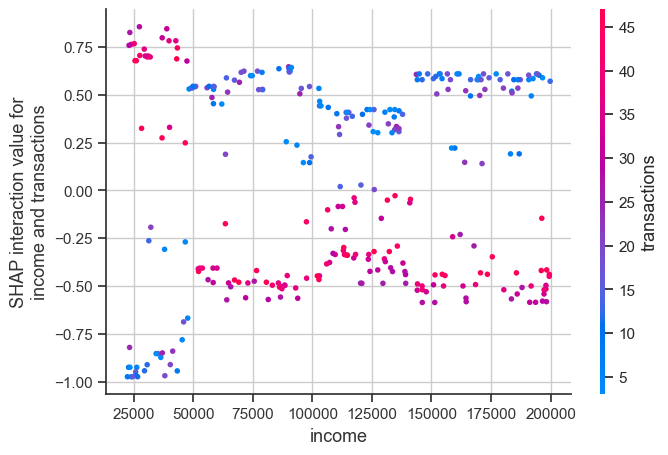

In [74]:
shap_interactions = explainer.shap_interaction_values(X)

# ------------------------------------------------------------
# Plot interaction between income and transactions
# ------------------------------------------------------------
shap.dependence_plot(
    ("income", "transactions"),
    shap_interactions,
    X
)


In [75]:
top_features = importance_df["feature"].head(2).tolist()
top_features

['income', 'tenure']

C:\Users\ankit\AppData\Local\Temp\ipykernel_25660\994215437.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X)


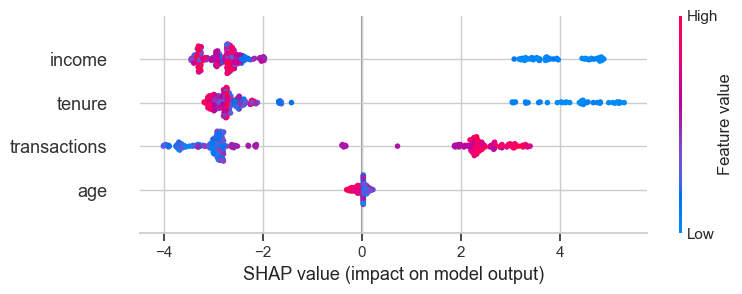

In [76]:
shap.summary_plot(shap_values.values, X)

# Lasso for Feature Selection
 Lasso (L1‑regularized regression) performs feature selection by shrinking coefficients toward zero.
 Features that don’t contribute to the prediction get a coefficient of exactly zero — meaning they can be safely removed.
 This makes Lasso a simple, fast, and effective way to reduce dimensionality, especially when features are correlated.


In [77]:
# ------------------------------------------------------------
# Sample dataset
# ------------------------------------------------------------
np.random.seed(42)

df = pd.DataFrame({
    "age": np.random.randint(18, 70, 200),
    "income": np.random.randint(20000, 200000, 200),
    "transactions": np.random.randint(1, 50, 200),
    "tenure": np.random.randint(1, 15, 200)
})

# Create fraud.
df["fraud_flag"] = (
    (df["transactions"] > 25).astype(int) +
    (df["income"] < 50000).astype(int)
)
df["fraud_flag"] = (df["fraud_flag"] > 0).astype(int)

X = df.drop("fraud_flag", axis=1)
y = df["fraud_flag"]

# ------------------------------------------------------------
# Scale features (important for Lasso)
# ------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------------
# Lasso model
# ------------------------------------------------------------
lasso = Lasso(alpha=0.05)
lasso.fit(X_scaled, y)

# ------------------------------------------------------------
# Feature importance from coefficients
# ------------------------------------------------------------
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lasso.coef_
}).sort_values("coefficient", key=np.abs, ascending=False)

print(coef_df)

        feature  coefficient
2  transactions     0.337894
1        income    -0.025697
0           age     0.000000
3        tenure     0.000000


In [78]:
selected = coef_df[coef_df["coefficient"] != 0]["feature"].tolist()
selected

['transactions', 'income']